# Results for Finger Motion

This notebook contains results for finger motion.

In [78]:
import sys
import numpy as np
import setup
import tensorflow as tf
import pandas as pd
import data_utils as dutils
import archive_5point_model as pt5
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import normalize, Normalizer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## Utilities

In [79]:
N_LABELS = 4    

def tfutil_run(mtype='basic', epochs=500, data=None):
    nftrs = data.shape[1] - N_LABELS
    
    # Prepare the data
    X, y = dutils.prepare_data_imputed_norm(data[:, :nftrs], data[:, nftrs:])

    # Split train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    # Create the model
    if mtype == 'basic':
        model = tf.keras.models.Sequential([
            tf.keras.Input(shape=(nftrs,), name="input"),
            tf.keras.layers.LayerNormalization(axis=1 , center=True , scale=True),
            tf.keras.layers.Dense(150, activation='relu'),
            tf.keras.layers.Dense(190, activation='relu'),
            tf.keras.layers.Dense(150, activation='relu'),
            tf.keras.layers.Dense(N_LABELS, activation='relu', name='output')
        ])
    else:
        print('Model not defined...')
        return
    
    # Compile the model
    model.compile(
        loss='mean_squared_error',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
    )

    # Fit the model
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        validation_split=.02,
        verbose=0,
    )

    # Evaluate the model
    score = model.evaluate(X_test, y_test)
    print(f'MSE={score}')
    
    # Display the table
    plt.plot(history.history['loss'][10:])
    plt.plot(history.history['val_loss'][10:])
    plt.title('Model Loss')
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()

## Section 1 – 5point glove model

These are the results from when we used a 5 point glove model.

### Raw datapoints

The accuracy of the model was really poor when we used raw datapoints. This is likely because the points were arbitrary points in screen space, our hands would move around a lot accidentally.

This shows that the model had an **UNREPRESENTATIVE VALIDATION SET** the dataset because the results remained flat.

10/10 [==============================] - 0s 1ms/step - loss: 12933.0898
MSE=12933.08984375


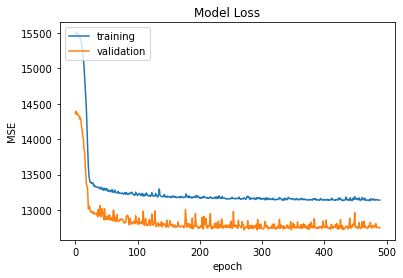

In [80]:
def do5pt_rawdatapoints():
    data = pd.read_csv('archive_5point_model/data/crouch00_raw_points.csv').values
    tfutil_run(
        mtype='basic',
        data=data
    )
    
do5pt_rawdatapoints()

### Just deltas

In this scenario, we used the ml to try and predict just deltas. This didn't work well because our error in rotation delta would buid up overtime. This way we were able to get a decently low MSE, but this won't work because if we're applying these delta rotation predictions at each frame, our model will get so far off of the target desired rotations.

This model shows that the model **OVERFIT** the dataset because the validation set diverged from the training set (an the validation set was much higher error).

21/21 [==============================] - 0s 2ms/step - loss: 202.4334
MSE=202.4333953857422


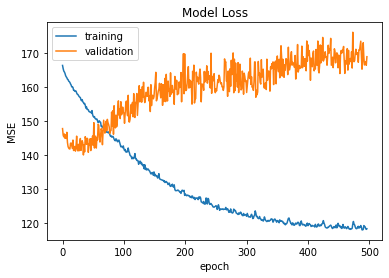

In [62]:
def do5pt_justdeltas():
    data = pd.read_csv('archive_5point_model/data/walk00_just_deltas.csv').values
    tfutil_run(
        mtype='basic',
        data=data
    )

do5pt_justdeltas()

### Vectors and mags

We use vectors and magnitudes, thinking it would help to determin the orientation of the fingers in 3d space because we were using mags. The results were very inconsistent. This could be because of a small dataset.

This model is **UNDERFITTING**

10/10 [==============================] - 0s 1ms/step - loss: 7603.1396
MSE=7603.1396484375


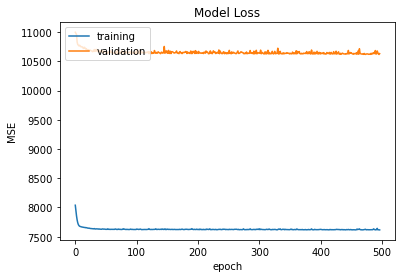

In [63]:
def do5pt_vecandmag():
    data = pd.read_csv('archive_5point_model/data/crouch00_vectors_and_mags.csv').values
    tfutil_run(
        mtype='basic',
        data=data
    )

do5pt_vecandmag()

## Section 2 – 6point glove model

We switched to use a 6 point model to help get some orientation for the hips.

### Raw datapoints

With the 6 point  model, the accuracy increased, but still wasn't perfect. Again performed very poorly.

This model has an **UNREPRESENTATIVE VALIDATION SET** (E.g. the VS doesn't represent the training set). This means that the data was too inconsistent to provided reliable info, this is most likely because the data is raw data in screen space coordinates.

22/22 [==============================] - 0s 1ms/step - loss: 3699.8083
MSE=3699.808349609375


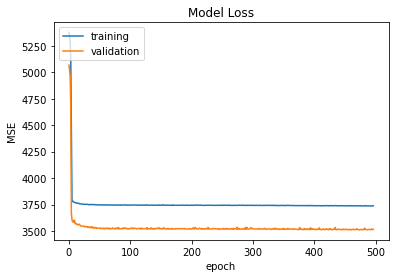

In [64]:
def do6pt_rawdatapoints():
    data = pd.read_csv('data/crouchraw_josiah_01.csv').values
    tfutil_run(
        mtype='basic',
        data=data
    )

do6pt_rawdatapoints()

### Big hefty

We decided create a features set with a lot of different features imputed from the raw dataset. These features consistently reported better results. We found out that the more data we added, the more the machine improved.

The basic model didn't perform super well in most cases. Typically resulting in a lot of underfitting.

The bifhefty model (with more layers with sigmoids etc) had much better preformance.

180/180 [==============================] - 0s 2ms/step - loss: 30.3377
MSE=30.337692260742188


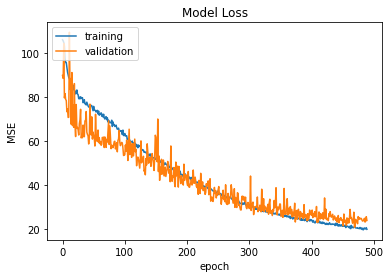

In [82]:
def do6pt_bighefty2():
    data = pd.read_csv('data/bighefty2.csv').values
    tfutil_run(
        mtype='basic',
        data=data
    )

do6pt_bighefty2()